In [1]:
from transformers import GPT2LMHeadModel

In [2]:
model_hf = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
sd_hf = model_hf.state_dict()

for k, v in sd_hf.items():
    print(k, v.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

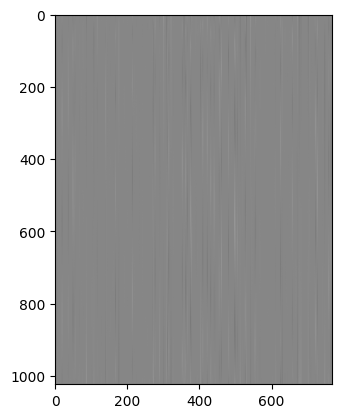

In [3]:
import matplotlib.pyplot as plt
# you will see a structure in the plot which shows that positional encoding learned their position in the sequence length of 1024
plt.imshow(sd_hf["transformer.wpe.weight"], cmap="gray")

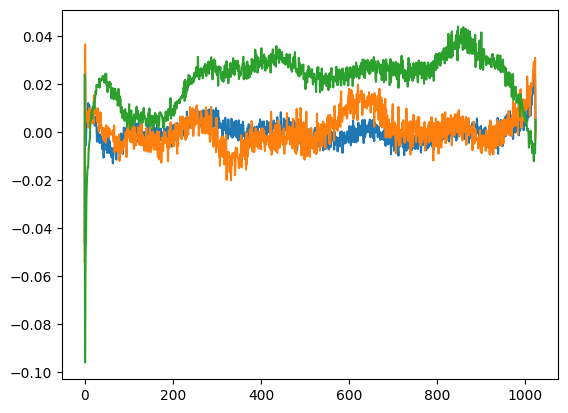

In [4]:
# now lets plot some of the positional encoding, you will notice that the behaviour of every one of them is different some fires after every 200 sequence and others have some other behaviour
plt.plot(sd_hf["transformer.wpe.weight"][:, 150])
plt.plot(sd_hf["transformer.wpe.weight"][:, 200])
plt.plot(sd_hf["transformer.wpe.weight"][:, 250])
# and notice that the curves are not really smooth which POSSIBLY tells that the model was undertrained

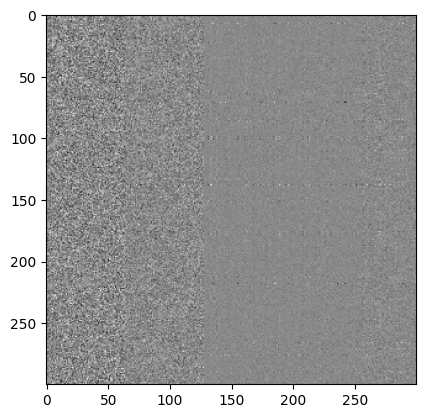

In [5]:
plt.imshow(sd_hf["transformer.h.1.attn.c_attn.weight"][:300,:300], cmap="gray")

In [6]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so I can write things that are easy to understand with help of my programming language."\n\nHowever, this'},
 {'generated_text': "Hello, I'm a language model, I've had years of experience with languages, but here I'm a native speaker. So I was kind of"},
 {'generated_text': "Hello, I'm a language model, I need to understand and understand languages.\n\nBut I don't necessarily think we can use language models to"},
 {'generated_text': 'Hello, I\'m a language model, this is a language model, and when somebody calls you, you don\'t hear this very often anyway," he'},
 {'generated_text': "Hello, I'm a language model, not a language model. I mean, the basic premise for modeling languages with Ocamlp is that each value"}]

#### some points to write in the readme file of the repo
 - decoder only transformer without the cross attention
 - some difference from the `attention is all you need` transformer settings
 - placement of the layer norms and the residual connections
 - difference between relu and gelu with their formulas and the graph and then the differnece with the approximate version of gelu (tanh one)


***difference between relu and gelu***

- in relu as you can also see in the graph, that it is completely flat at 0, but this is not the case in the gelu activation
- there is no change there is no adaptation there is no neural network progression cause the gradient will be 0

---

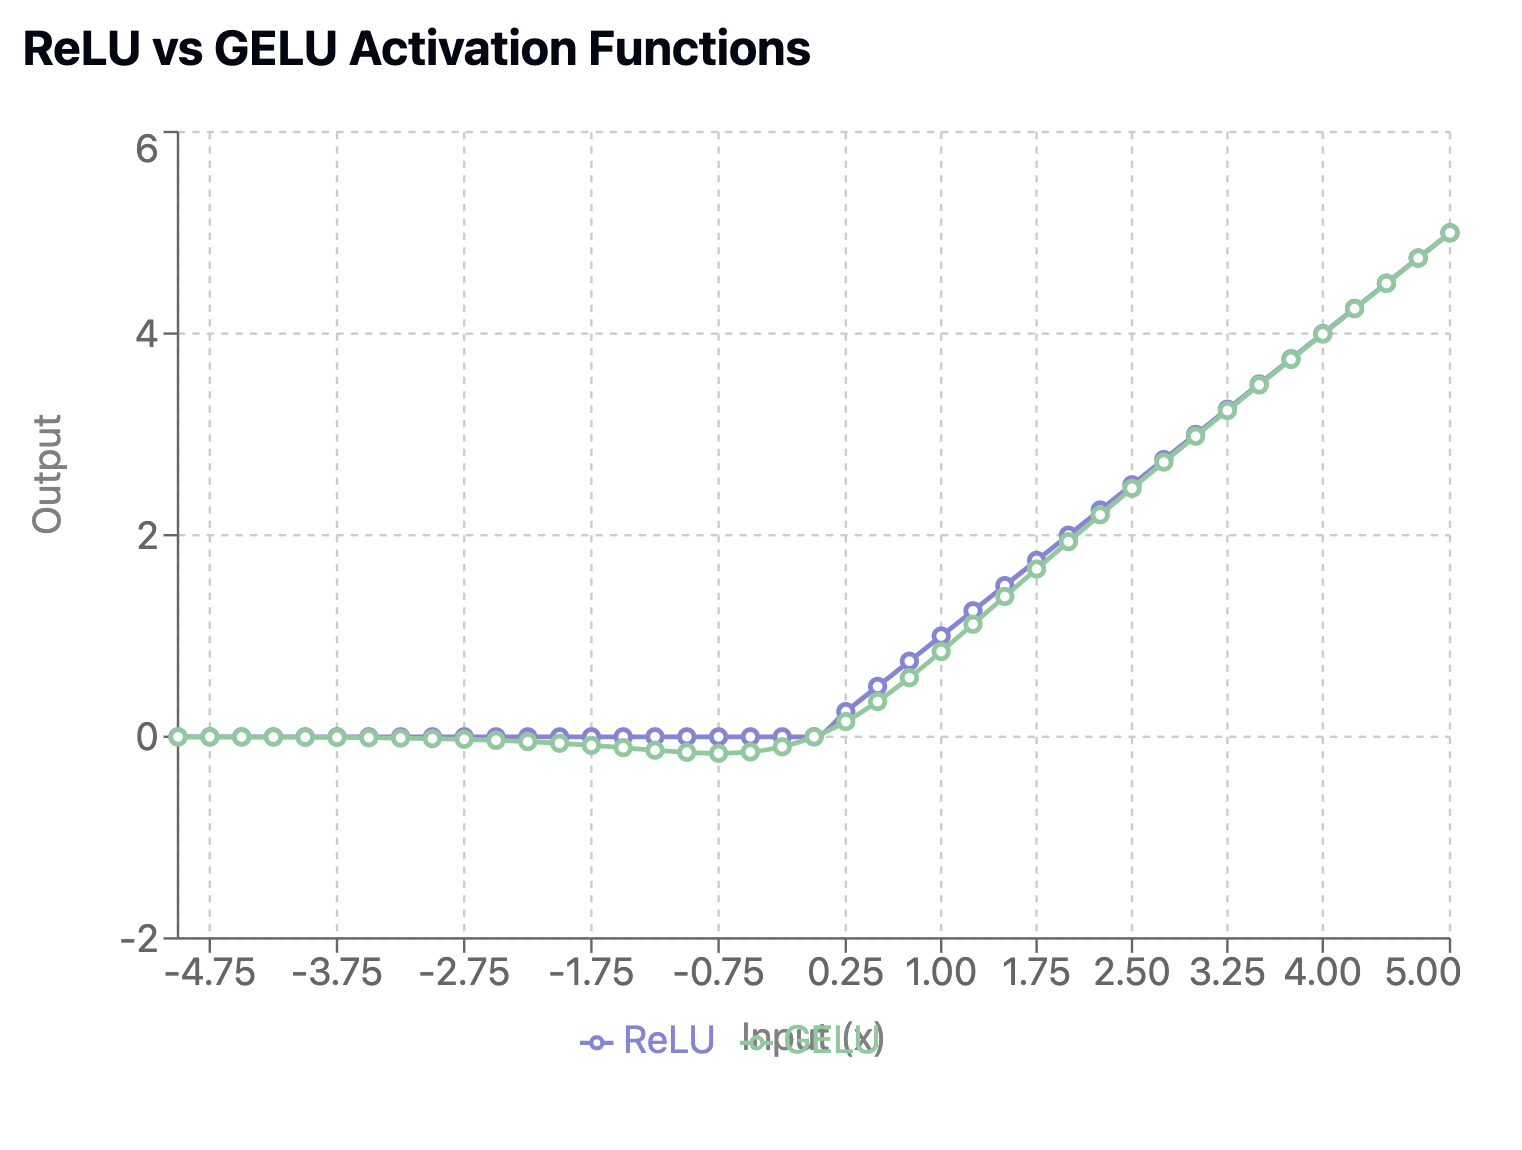



> ***testing all the train_gpt2 code here cause i dont wanna pollute my laptop lol***

#### checking if it loades the weight

In [7]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

class CasualSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, will split it later
        # the k,q,v are of size (n_emdb, n_embd)
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2) # This line splits the concatenated qkv tensor into separate query, key and value tensors along dimension 2 (channel dimension)
        # here multi head attention is done in a single casual self attention block
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) * (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y



class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd,4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd,config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = CasualSelfAttention(config)
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    # def forward(self, idx):
    #         B,T = idx.shape # the input idx is always in the shape of (B,T)
    #         assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
    #         pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
    #         wpe = self.transformer.wpe(pos)
    #         wte = self.transformer.wte(idx)
    #         x = wpe + wte
    #         # making it go through all the blocks of the transformers
    #         for block in self.transformer.h:
    #                     x = block(x)
    #         logits = self.lm_head(self.transformer.ln_f(x))
    #         return logits

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)
        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model
# -----------------------------------------------------------------------------
model = GPT.from_pretrained('gpt2')
print("it workedddd!")


loading weights from pretrained gpt: gpt2
it workedddd!


#### sampling

In [8]:
from transformers import pipeline, set_seed
generator = pipeline('text-generation', model='gpt2')
set_seed(42)
generator("Hello, I'm a language model,", max_length=30, num_return_sequences=5)

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Hello, I\'m a language model, so I can write things that are easy to understand with help of my programming language."\n\nHowever, this'},
 {'generated_text': "Hello, I'm a language model, I've had years of experience with languages, but here I'm a native speaker. So I was kind of"},
 {'generated_text': "Hello, I'm a language model, I need to understand and understand languages.\n\nBut I don't necessarily think we can use language models to"},
 {'generated_text': 'Hello, I\'m a language model, this is a language model, and when somebody calls you, you don\'t hear this very often anyway," he'},
 {'generated_text': "Hello, I'm a language model, not a language model. I mean, the basic premise for modeling languages with Ocamlp is that each value"}]

In [9]:
!pip install tiktoken

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 19.1 MB/s eta 0:00:00


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
import torch
from torch.nn import functional as F

model = GPT2LMHeadModel.from_pretrained("gpt2") # 124M
model.eval()
model.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
tokens = [15496, 11, 314, 1101, 257, 3303, 2746, 11] # "Hello, I'm a language model,"
tokens = torch.tensor(tokens, dtype=torch.long) # (8,)
tokens = tokens.unsqueeze(0).repeat(5, 1) # (5, 8)
x = tokens.to(device)
# generate!
while x.size(1) < 30: # max_length=30
    # forward the model to get the logits
    with torch.no_grad():
        logits = model(x)[0] # (B, T, vocab_size)
        # take the logits at the last position
        logits = logits[:, -1, :] # (B, vocab_size)
        # get the probabilities
        probs = F.softmax(logits, dim=-1)
        # do top-k sampling of 50 (huggingface pipeline default)
        # topk_probs here becomes (5, 50), topk_indices is (5, 50)
        topk_probs, topk_indices = torch.topk(probs, 50, dim=-1)
        # select a token from the top-k probabilities
        # note: multinomial does not demand the input to sum to 1
        ix = torch.multinomial(topk_probs, 1) # (B, 1)
        # gather the corresponding indices
        xcol = torch.gather(topk_indices, -1, ix) # (B, 1)
        # append to the sequence
        x = torch.cat((x, xcol), dim=1)

# print the generated text
import tiktoken
enc = tiktoken.get_encoding('gpt2')
for i in range(5):
    tokens = x[i, :30].tolist()
    decoded = enc.decode(tokens)
    print(">", decoded)

> Hello, I'm a language model, not a program.

So this morning I started studying for the interview in the lab. This was not
> Hello, I'm a language model, and one of the main things that bothers me when they create languages is how easy it becomes to create something that
> Hello, I'm a language model, and I wrote it off on the grounds that a language model would make me more fluent. But I'm not
> Hello, I'm a language model, I really like languages. I like languages because like, they're good. And the way we talk about languages
> Hello, I'm a language model, a language model I'm using for data modelling. All I did was test the results and then I wrote some


In [12]:
# tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r') as f:
    text = f.read()
data = text[:1000] # first 1,000 characters
print(data[:100])

--2025-02-06 15:43:13--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.04s   

2025-02-06 15:43:14 (23.8 MB/s) - ‘input.txt’ saved [1115394/1115394]

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [13]:
import tiktoken
enc = tiktoken.get_encoding('gpt2')
tokens = enc.encode(data)
print(tokens[:24])

[5962, 22307, 25, 198, 8421, 356, 5120, 597, 2252, 11, 3285, 502, 2740, 13, 198, 198, 3237, 25, 198, 5248, 461, 11, 2740, 13]


#### about creating a dataloader object

*so what we are seeing is that `x` is the input(which we will feed into the transformer) and  `y` is the targets(which have one more token than the input)*

In [14]:
import torch
buf = torch.tensor(tokens[:24 + 1])
x = buf[:-1].view(4, 6)
y = buf[1:].view(4, 6)
print(x)
print(y)

tensor([[ 5962, 22307,    25,   198,  8421,   356],
        [ 5120,   597,  2252,    11,  3285,   502],
        [ 2740,    13,   198,   198,  3237,    25],
        [  198,  5248,   461,    11,  2740,    13]])
tensor([[22307,    25,   198,  8421,   356,  5120],
        [  597,  2252,    11,  3285,   502,  2740],
        [   13,   198,   198,  3237,    25,   198],
        [ 5248,   461,    11,  2740,    13,   198]])


#### some notes about loss:
the intial model (without training) should give a loss around: $$-\log\left(\frac{1}{\text{vocab_size}}\right)$$

so in this case it should have been $$-\log\left(\frac{1}{\text{50257}}\right)=10.82$$

but the loss came out to be 11.0886 so it is okay

#### training the model

In [16]:
import math
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F

class CasualSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, will split it later
        # the k,q,v are of size (n_emdb, n_embd)
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        # not really a 'bias', more of a mask, but following the OpenAI/HF naming though
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        # e.g. in GPT-2 (124M), n_head=12, hs=64, so nh*hs=C=768 channels in the Transformer
        qkv = self.c_attn(x)
        q, k, v = qkv.split(self.n_embd, dim=2) # This line splits the concatenated qkv tensor into separate query, key and value tensors along dimension 2 (channel dimension)
        # here multi head attention is done in a single casual self attention block
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # attention (materializes the large (T,T) matrix for all the queries and keys)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) * (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.c_proj(y)
        return y

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd,4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(4 * config.n_embd,config.n_embd)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attn = CasualSelfAttention(config)
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

@dataclass
class GPTConfig:
    block_size: int = 1024 # max sequence length
    vocab_size: int = 50257 # number of tokens: 50,000 BPE merges + 256 bytes tokens + 1 <|endoftext|> token
    n_layer: int = 12 # number of layers
    n_head: int = 12 # number of heads
    n_embd: int = 768 # embedding dimension


class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

    def forward(self, idx, targets = None):
            B,T = idx.shape # the input idx is always in the shape of (B,T)
            assert T <= self.config.block_size, f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
            pos = torch.arange(0, T, dtype=torch.long, device=idx.device)
            wpe = self.transformer.wpe(pos)
            wte = self.transformer.wte(idx)
            x = wpe + wte
            # making it go through all the blocks of the transformers
            for block in self.transformer.h:
                        x = block(x)
            logits = self.lm_head(self.transformer.ln_f(x))
            loss = None
            if targets != None:
                loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
            return logits, loss

    @classmethod
    def from_pretrained(cls, model_type):
        """Loads pretrained GPT-2 model weights from huggingface"""
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)
        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param
        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()
        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])
        return model
# -----------------------------------------------------------------------------
# attempt to autodetect the device
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available(): # apple silicone gpu
    device = "mps"
print(f"using device: {device}")

# get a data batch
import tiktoken
enc = tiktoken.get_encoding('gpt2')
with open('input.txt', 'r') as f:
    text = f.read()
text = text[:1000]
tokens = enc.encode(text)
B, T = 4, 32
buf = torch.tensor(tokens[:B*T + 1])
buf = buf.to(device)
x = buf[:-1].view(B, T)
y = buf[1:].view(B, T)

model = GPT(GPTConfig())
# get logits
logits, loss = model(x, y)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
for i in range(50):
    logits, loss = model(x, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(f"step {i}, loss: {loss.item()}")

using device: cuda
step 0, loss: 11.039793014526367
step 1, loss: 6.663135528564453
step 2, loss: 4.343545913696289
step 3, loss: 2.6630969047546387
step 4, loss: 1.5425658226013184
step 5, loss: 0.8596519231796265
step 6, loss: 0.47345730662345886
step 7, loss: 0.2705487608909607
step 8, loss: 0.17726245522499084
step 9, loss: 0.11991288512945175
step 10, loss: 0.08215321600437164
step 11, loss: 0.06201287731528282
step 12, loss: 0.04918515682220459
step 13, loss: 0.03781944140791893
step 14, loss: 0.03079790063202381
step 15, loss: 0.027178073301911354
step 16, loss: 0.02420632541179657
step 17, loss: 0.020987724885344505
step 18, loss: 0.01815553568303585
step 19, loss: 0.015954267233610153
step 20, loss: 0.014240267686545849
step 21, loss: 0.01288440078496933
step 22, loss: 0.011722775176167488
step 23, loss: 0.010638335719704628
step 24, loss: 0.009627247229218483
step 25, loss: 0.008733062073588371
step 26, loss: 0.00796867161989212
step 27, loss: 0.0073196906596422195
step 28, l

> ***in the above dataset we basically just overfitted on a single batch but in the next step we will implement a data loader and then  use it to bring other batches to the model too and then our model will not overfit***

#### note about some bug:

**so what was differnet between our implementation of gpt2 and the huggingface/original was that we were not sharing parameters of lm_head and wte but we have to do it**

**we do this because we want this two matrices to behave in the similar manner cause we want the same probabilities in the output, so the starting and final step of transformer share the weight matrix**

---
#### about the initialization of the gpt2 model
- the std deviation of the linear layer should be 0.02 (it is 0.02 cause if it is calculated by 1/sqrt(d_model) and the average value of the d_model of the gpt2 series is 0.02
- we want to initialize the bias with zeros
- we scale the weights of residual path by the factor of 1/sqrt(N), where N is the no of layers



---

####more about the residual path/stream problem
- In transformer architectures, each layer adds its output to the residual stream (output = input + layer_output), which causes the variance of activations to accumulate and grow linearly with network depth.
- Without scaling, after n layers, the variance becomes n*V (where V is the initial variance), leading to potential activation explosions and training instability.
- To solve this, GPT-2 scales down each layer's output by 1/√n, where n = 2*num_layers (doubled because each transformer layer has two residual connections: one after attention and one after MLP).
- This scaling factor ensures that after n layers, the total variance remains constant (V) instead of growing to nV, as the scaled variance becomes n(V/n) = V.
- The result is more stable training, balanced layer contributions, and predictable behavior regardless of model depth, which is crucial for deep transformers that can be hundreds of layers.

---

#### intuition
you're adding dice rolls together:

Layer 1: You roll a die (random output) → Some random number <br>
Layer 2: You add another die roll → More randomness added <br>
Layer 3: Add another die roll → Even more randomness <br>
...and so on

Just like adding more dice rolls makes your total number more unpredictable and likely to get larger, each transformer layer adds its own "random" contribution to the residual stream, making the signal increasingly noisy and potentially too large.

PyTorch's default data type is torch.float32, but the A100 GPU architecture cannot fully utilize its potential with this precision.<br>
To optimize performance, we'll use torch.float32 in TensorFloat-32 (TF32) mode, which provides better hardware utilization and computational efficiency

---

#### using mixed precision

when using bfloat16 with mixed precision pytorch will use bfloat16 for some things(like logits) and then it will use torch.float32 for other things(like wte, wpe etc)

---

#### some useful images related to this:

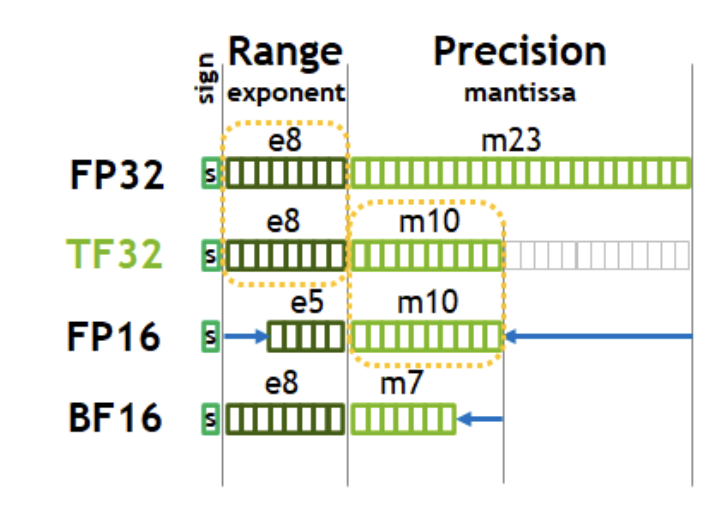

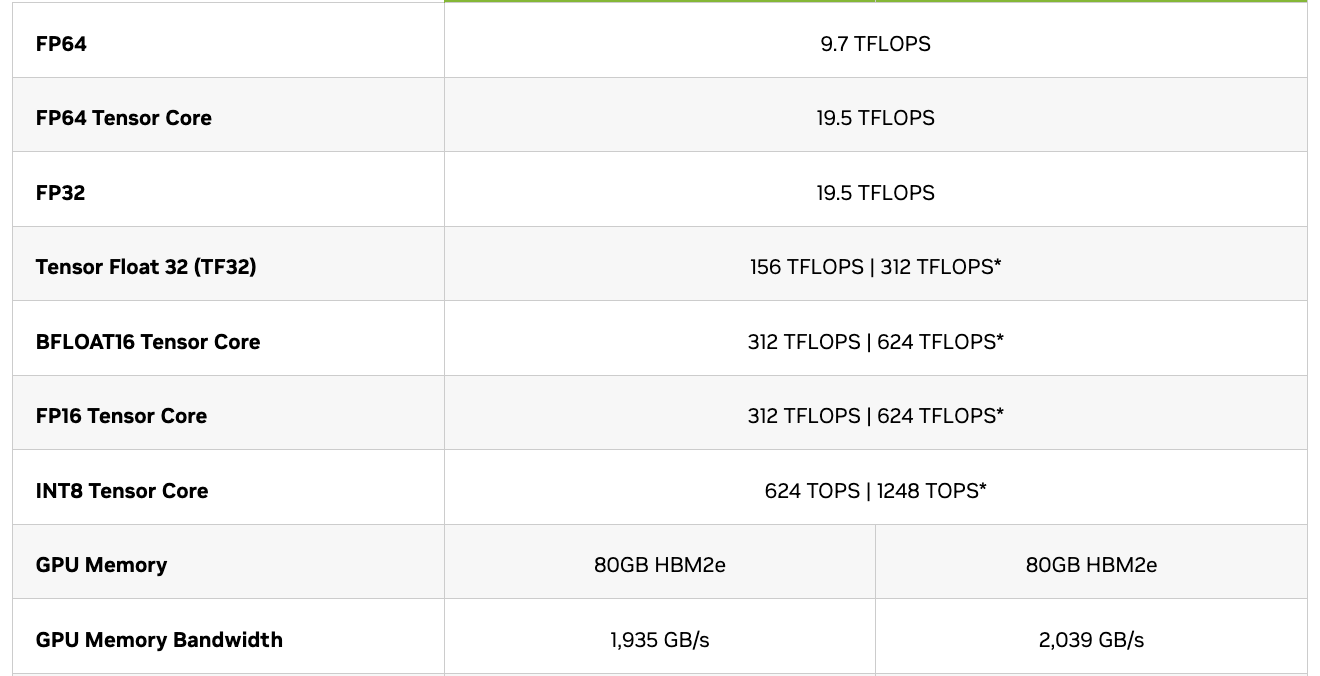

---

#### some tables to summarize what we have learned

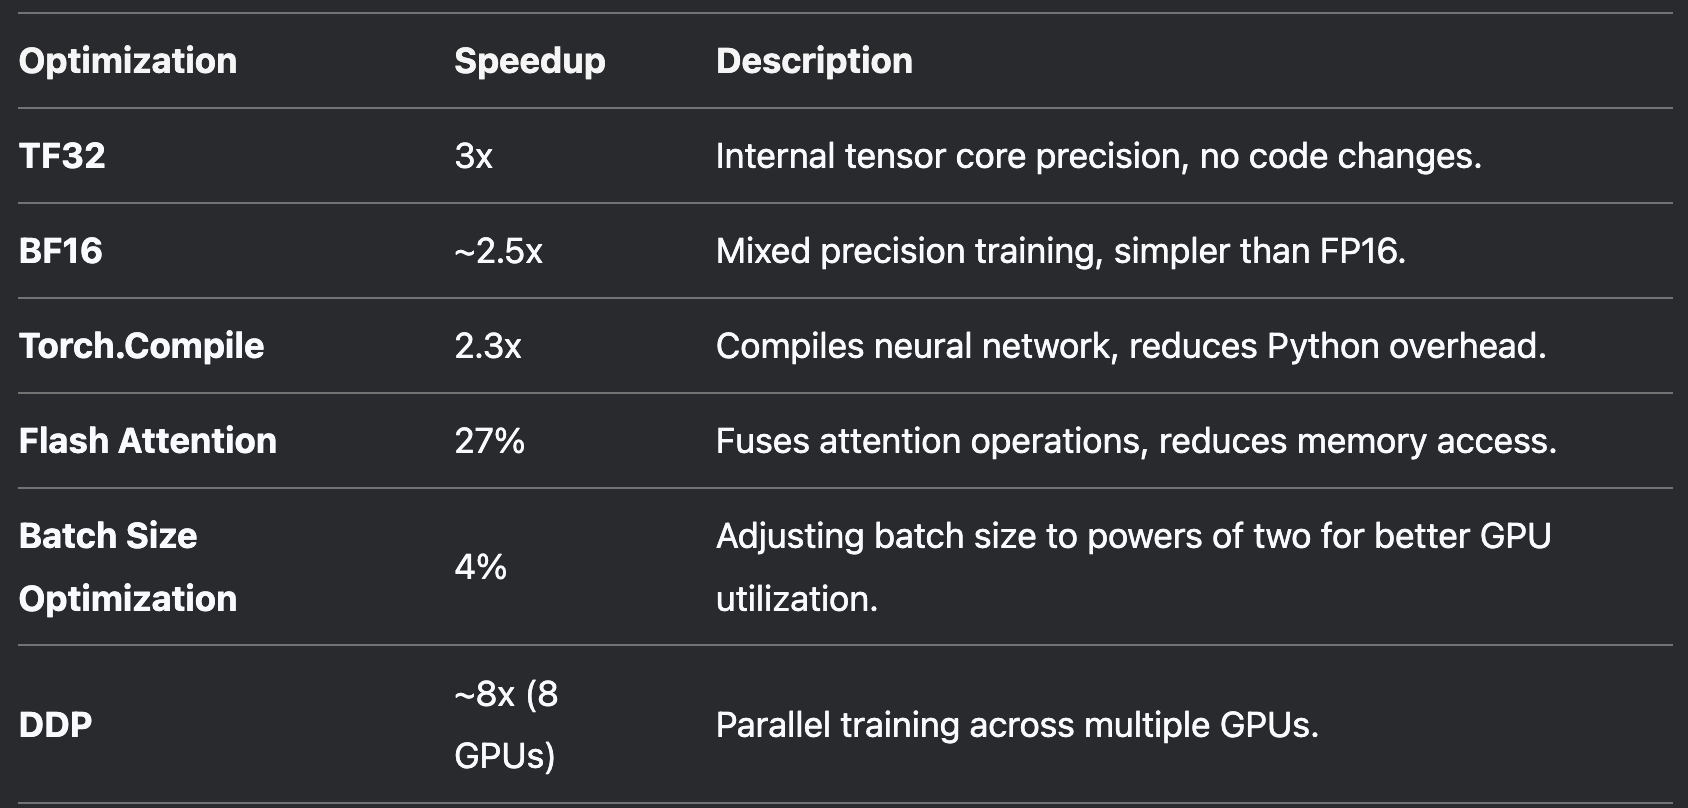

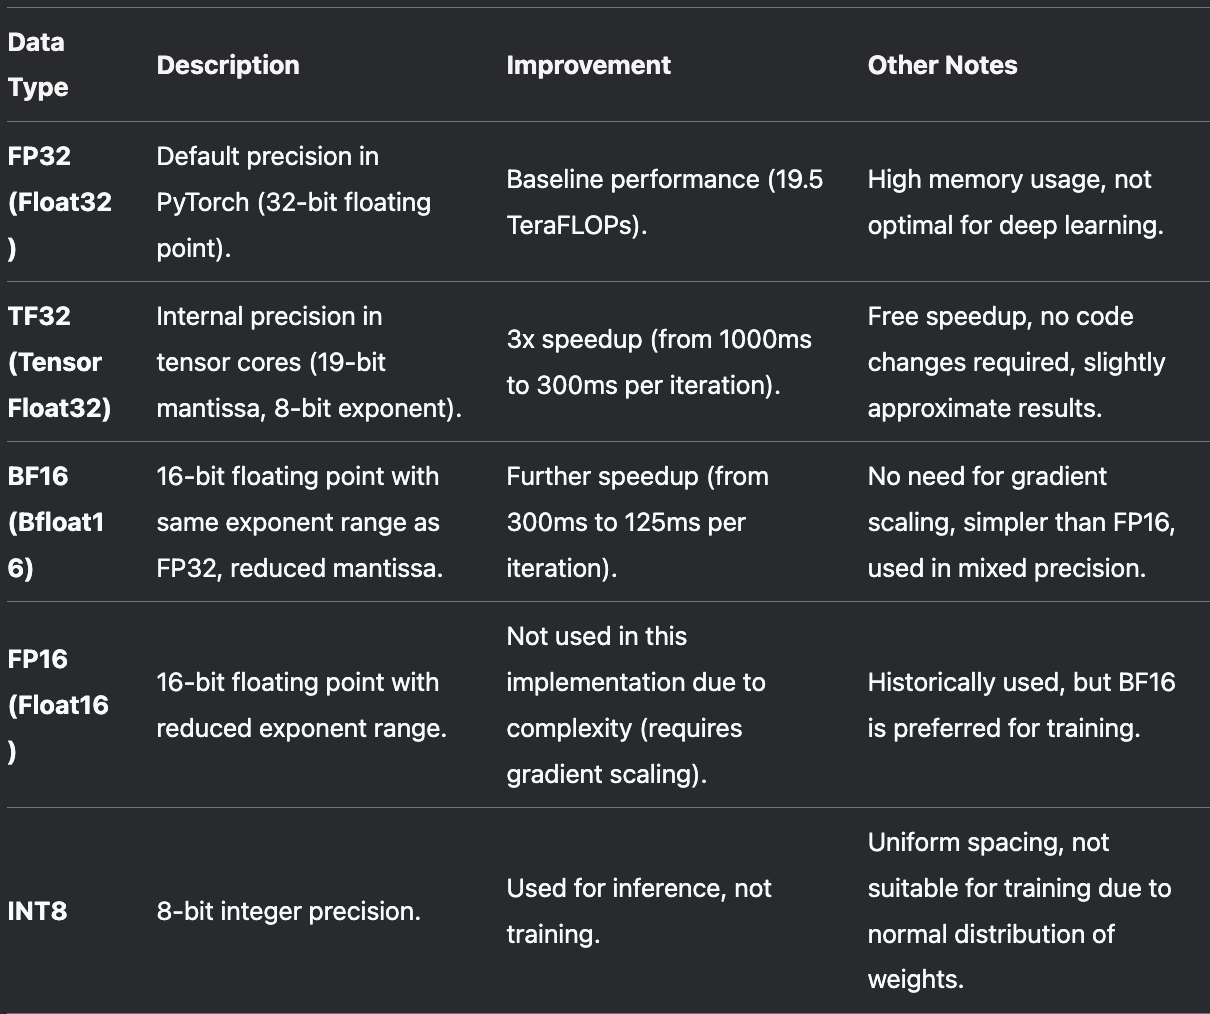

---

#### using torch.compile

increases the perfomance(reduces computation time)

---

- torch.compile sees your all the code at the same time(unlike the python interpereter which doesnot know which thing code/operation will come after that) and optimizes it(there is no python interpereter involved)
- it makes the going back and forth with the memory less (optimize the round trips) and we will not pay the memory bandwith cost anymore
- kernel fusion - allows you to keep the data on the chip and it makes the back and forth less



---
for more detail → https://docs.google.com/document/d/1y5CRfMLdwEoF1nTk9q8qEu1mgMUuUtvhklPKJ2emLU8/edit?tab=t.0

---

#### flash attention

---

so what flash attention does is that the $N \times N$ attention matrix never gets read or written to the hbm(it stays on the chip)

---
# > ***some times the flops dont matter knowing about memory hierachy matters***

#### **one silly optimization**

so we want to the `vocab_size` to be in the power of 2, cause many cuda kernels work in sort of power of 2

#### **about weight decay**

Weight decay is a regularization technique used in machine learning to prevent overfitting by discouraging excessively large weights in a model. It works by adding a penalty term to the loss function that depends on the magnitude of the model’s weights.

Mathematical Formulation

Weight decay is typically implemented using L2 regularization, where the modified loss function becomes:


$$L = L_{\text{original}} + \lambda \sum{i} w_i^2$$

	•	 L_original is the original loss (e.g., cross-entropy, MSE).
	•	 w_i are the model’s parameters (weights).
	•	 $\lambda$  (weight decay factor) controls the strength of regularization.

This penalty encourages smaller weights, reducing model complexity and improving generalization.

Effect on Gradient Descent

When using gradient-based optimization (e.g., SGD), the weight update rule changes to:


$$w \leftarrow w - \eta \left( \frac{\partial L_{\text{original}}}{\partial w} + 2\lambda w \right)$$


where:<br>
	•	 $\eta$  is the learning rate. <br>
	•	 $\lambda$ w  acts as a shrinking force on the weights.

Why Use Weight Decay?<br>
	1.	Prevents Overfitting: Large weights can cause a model to memorize training data instead of generalizing well.<br>
	2.	Encourages Simplicity: Reduces the risk of over-complex models that may perform poorly on unseen data.<br>
	3.	Improves Generalization: Makes models more robust to variations in input data.<br>

Weight Decay in Optimizers<br>
	•	SGD with L2 Regularization: Directly applies weight decay by modifying the weight update rule.<br>
	•	AdamW (Decoupled Weight Decay): Separates weight decay from Adam’s adaptive updates to improve stability.<br>

PyTorch Implementation Example
<br>
In PyTorch, weight decay can be set in the optimizer:<br>

```python
import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
```

#### **gradient acculumation and batch size**

so in the gpt3 paper they use the batch size of 0.5M but if we do that even on some 4-8 A100 the gpus will explode so what we need to do is use the technique knowns as gradient acculumation

#### gradient accumulation in deep learning  

**gradient accumulation** is a technique used in deep learning to simulate larger batch sizes by accumulating gradients over multiple mini-batches before updating the model weights. this is particularly useful when working with limited gpu memory.  

---

## why use gradient accumulation?  
1. **overcome memory constraints:** instead of using a large batch size (which may not fit in memory), gradients from multiple smaller batches are accumulated and applied at once.  
2. **improve stability:** larger effective batch sizes result in more stable updates and better generalization.  
3. **match performance of large-batch training:** allows training with small batches while mimicking the behavior of larger batches.  

---

## how gradient accumulation works  
instead of updating the model parameters after every mini-batch, we do the following:  

1. compute gradients for a mini-batch.  
2. accumulate gradients over multiple mini-batches (without updating parameters).  
3. after a certain number of steps ($\text{accumulation steps}$), update the model weights.  
4. reset the accumulated gradients and repeat.  

---

## mathematical formulation  
given:  
- $B$ = batch size per step  
- $N$ = accumulation steps  
- $B_{\text{eff}} = B \times N$ (effective batch size)  
- $\theta$ = model parameters  
- $\eta$ = learning rate  

for each mini-batch $i$:  
1. compute gradients:  
   $$
   g_i = \frac{1}{B} \sum_{j=1}^{B} \nabla_{\theta} L_j
   $$  
2. accumulate gradients:  
   $$
   G = G + g_i
   $$  
3. after $N$ steps, update weights:  
   $$
   \theta = \theta - \eta G
   $$  
4. reset $G$ and repeat.  

---


#### some intuition about gradient accumulation

when we are calculating loss in batch of 4 together, we are normalizing the loss by $\frac{1}{4}$ (in case of using MSE loss), but when doing gradient accumulation what we do wrong is that we will use batch of 1, 4 times and the batch size is of one so the loss will be nromalized by 1 basically nothing is normalized so we have to fix this (**see in the code example by karpathy below**)

In [1]:
import torch

# super simple little MLP
net = torch.nn.Sequential(
    torch.nn.Linear(16, 32),
    torch.nn.GELU(),
    torch.nn.Linear(32, 1)
)
torch.random.manual_seed(42)
x = torch.randn(4, 16)
y = torch.randn(4, 1)
net.zero_grad()
yhat = net(x)
loss = torch.nn.functional.mse_loss(yhat, y)
loss.backward()
print(net[0].weight.grad.view(-1)[:10])

# the loss objective here is (due to readuction='mean')
# L = 1/4 * [
#            (y[0] - yhat[0])**2 +
#            (y[1] - yhat[1])**2 +
#            (y[2] - yhat[2])**2 +
#            (y[3] - yhat[3])**2
#           ]
# NOTE: 1/4!

tensor([ 0.1302,  0.0306, -0.0254, -0.0203, -0.0170,  0.0013,  0.0710,  0.1229,
         0.1430,  0.0434])


In [7]:
# now let's do it with grad_accum_steps of 4, and B=1
# the loss objective here is different because
# accumulation in gradient <---> SUM in loss
# i.e. we instead get:
# L0 = 1/4(y[0] - yhat[0])**2
# L1 = 1/4(y[1] - yhat[1])**2
# L2 = 1/4(y[2] - yhat[2])**2
# L3 = 1/4(y[3] - yhat[3])**2
# L = L0 + L1 + L2 + L3
# NOTE: the "normalizer" of 1/4 is lost


net.zero_grad()
for i in range(4):
    yhat = net(x[i])
    loss = torch.nn.functional.mse_loss(yhat, y[i]) / 4  # Distribute loss across steps# <-- loss at this////have to add back the "normalizer"! yayayyaya
    loss.backward()
print(net[0].weight.grad.view(-1)[:10])

tensor([ 0.1302,  0.0306, -0.0254, -0.0203, -0.0170,  0.0013,  0.0710,  0.1229,
         0.1430,  0.0434])


#### about using hellaswag eval

so it is an evaluation that is completely crushed as of now, but it is still very prominent in case of our model(open ai also used this evaluation while evaluating gpt3)

**it has a random score of 25%(which means almost every state of the art model will be able to get 25% if our model will be good then we will be able to slowly increase from 25%)**

#### image on how we are going to use the eval
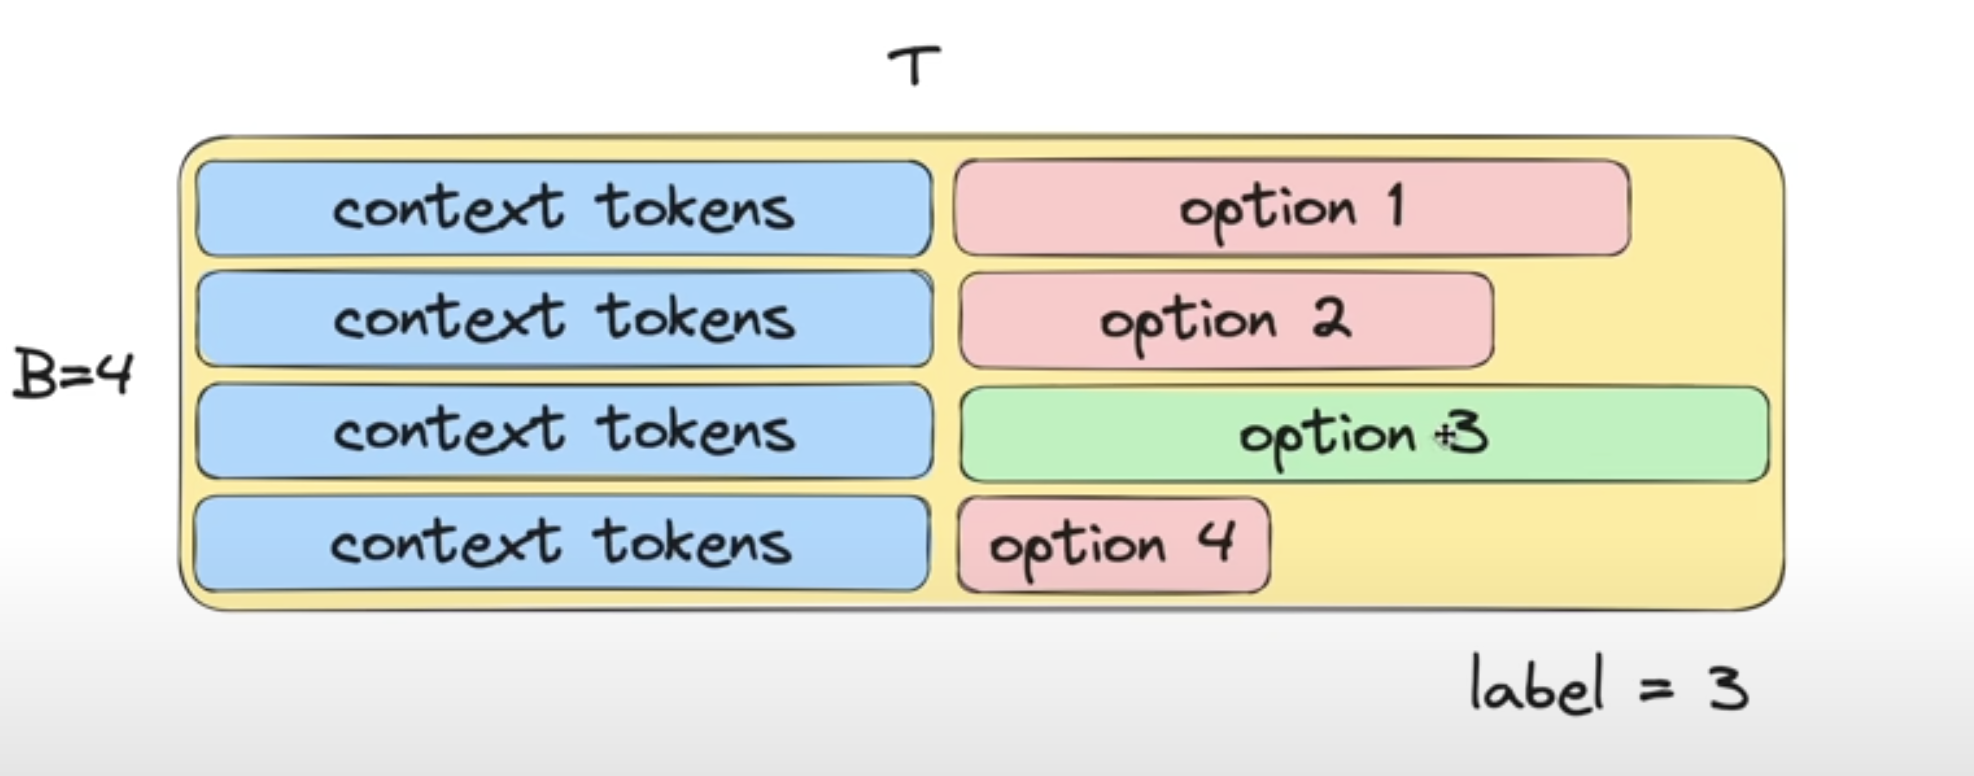

#### finally plotting the results lfggggg

In [ ]:
# parse and visualize the logfile
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

sz = "124M"

loss_baseline = {
    "124M": 3.2924,
}[sz]
hella2_baseline = { # HellaSwag for GPT-2
    "124M": 0.294463,
    "350M": 0.375224,
    "774M": 0.431986,
    "1558M": 0.488946,
}[sz]
hella3_baseline = { # HellaSwag for GPT-3
    "124M": 0.337,
    "350M": 0.436,
    "774M": 0.510,
    "1558M": 0.547,
}[sz]

# load the log file
with open("log124M_40B/log.txt", "r") as f:
    lines = f.readlines()

# parse the individual lines, group by stream (train,val,hella)
streams = {}
for line in lines:
    step, stream, val = line.strip().split()
    if stream not in streams:
        streams[stream] = {}
    streams[stream][int(step)] = float(val)

# convert each stream from {step: val} to (steps[], vals[])
# so it's easier for plotting
streams_xy = {}
for k, v in streams.items():
    # get all (step, val) items, sort them
    xy = sorted(list(v.items()))
    # unpack the list of tuples to tuple of lists
    streams_xy[k] = list(zip(*xy))

# create figure
plt.figure(figsize=(16, 6))

# Panel 1: losses: both train and val
plt.subplot(121)
xs, ys = streams_xy["train"] # training loss
ys = np.array(ys)
plt.plot(xs, ys, label=f'nanogpt ({sz}) train loss')
print("Min Train Loss:", min(ys))
xs, ys = streams_xy["val"] # validation loss
plt.plot(xs, ys, label=f'nanogpt ({sz}) val loss')
# horizontal line at GPT-2 baseline
if loss_baseline is not None:
    plt.axhline(y=loss_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint val loss")
plt.xlabel("steps")
plt.ylabel("loss")
plt.yscale('log')
plt.ylim(top=4.0)
plt.legend()
plt.title("Loss")
print("Min Validation Loss:", min(ys))

# Panel 2: HellaSwag eval
plt.subplot(122)
xs, ys = streams_xy["hella"] # HellaSwag eval
ys = np.array(ys)
plt.plot(xs, ys, label=f"nanogpt ({sz})")
# horizontal line at GPT-2 baseline
if hella2_baseline:
    plt.axhline(y=hella2_baseline, color='r', linestyle='--', label=f"OpenAI GPT-2 ({sz}) checkpoint")
if hella3_baseline:
    plt.axhline(y=hella3_baseline, color='g', linestyle='--', label=f"OpenAI GPT-3 ({sz}) checkpoint")
plt.xlabel("steps")
plt.ylabel("accuracy")
plt.legend()
plt.title("HellaSwag eval")
print("Max Hellaswag eval:", max(ys))

So i finshed the training on 5000 epochs on 1 gpu for around ~10$, 
and loss was 3.370812, validation loss was 3.3529 and  HellaSwag accuracy was 2785/10042=0.2773 which is of course greater than random(25) but if i ran it for more epochs it wouldve been perfect for now its done